### Import relevant libraries

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
from dask.distributed import Client

from nilearn import image
from nilearn import input_data
from nilearn import plotting
from nilearn import signal

from bids import BIDSLayout
from load_confounds import Params9
from load_confounds import AnatCompCor

import process_bids as pb
import process_connectome as pc
import lib

pd.options.mode.chained_assignment = None

### Load and display brain parcellation

<Figure size 1440x720 with 0 Axes>

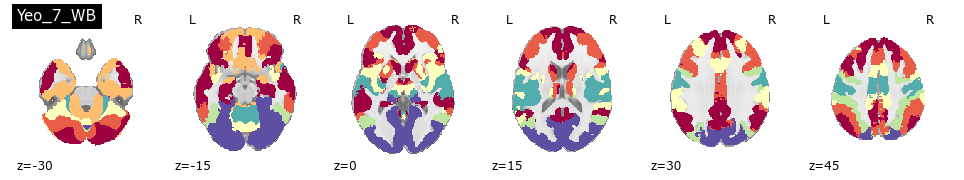

In [2]:
atlas_name = 'Yeo_7_WB'

atlas_path = os.path.abspath(r'..\..\atlas\Yeo\Yeo_WB\atlas_name.nii.gz'.replace('atlas_name',atlas_name))
atlas_masker = input_data.NiftiLabelsMasker(atlas_path, resampling_target="data", standardize=True,
                                            detrend=True, memory='nilearn_cache', memory_level=1)

anat_path = os.path.abspath(r'..\..\atlas\template_icbm_sym_09_white.nii')
atlas = image.load_img(atlas_path)
anat = image.load_img(anat_path)

fig = plt.figure(figsize=(20,10))

display = plotting.plot_anat(anat_img=anat,
                             display_mode='z',
                             cut_coords = [-30,-15,0,15,30,45],
                             title = atlas_name,
                             annotate = True,
                             draw_cross = False,
                             )

display.add_overlay(atlas,
                    colorbar=False,
                    cmap='Spectral_r')

### Parcel networks information

In [3]:
atlas_csv_path = os.path.abspath(r'..\..\atlas\Yeo\Yeo_WB\atlas_name_labels.csv'.replace('atlas_name',atlas_name))
atlas_csv = pd.read_csv(atlas_csv_path, sep=';', header = 0, names=['Index', 'Region name'], index_col=0)
region_pairwise = int(len(atlas_csv)*(len(atlas_csv)-1)/2)
atlas_csv.T

Index,1,2,3,4,5,6,7
Region name,visual,somatomotor,attentional,salience,limbic,central_executive,default_mode


### Load input data

In [4]:
dataset_name = 'msc'
raw_path = os.path.abspath('D:\msc-raw')
derivatives_path = os.path.abspath(r'D:\msc-derivatives\fmriprep')

# Lecture du format BIDS
layout = BIDSLayout(raw_path, derivatives = derivatives_path, validate = True,
                    database_path='pybids_True.sql', index_metadata=True, reset_database=False)

layout

### Input variables

In [5]:
subjects_id_list = layout.get_subjects()
tr = layout.get_tr(derivatives=True)

print('Subjects ID:', subjects_id_list)
print('The repetition time is', tr, 'secondes')

### Parallele processing for time series calculation

In [6]:
time_series_info = pd.DataFrame(columns = subjects_id_list, index = ['path','nlevels','tr','atlas'])
time_series_info.loc['tr',:] = tr
time_series_info.loc['atlas',:] = atlas_name

In [7]:
directory = 'timeSeries_files'
sub_dir = os.path.join(directory,dataset_name, atlas_name)
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

confounds_name = ['None', 'params9','aCompCor']

In [8]:
client = Client(threads_per_worker = 4, n_workers = 1)

In [9]:
results = []
for id in subjects_id_list:
    csv_path = os.path.join(sub_dir,'id_atlas_timeSeries.csv'.replace('id',id).replace('atlas',atlas_name))
    sessions_sub = pb.get_sessions(layout, id)
    tasks_by_session_sub = pb.get_tasks(layout, id, sessions_sub)
    run = pb.get_run(layout, id, sessions_sub, tasks_by_session_sub)
    time_series_df = pc.create_empty_df_timesseries(sessions_sub,tasks_by_session_sub, run, confounds_name)

    # Calcul sur l'ensemble des nifti
    subjects_im_path = layout.get(subject = id, extension='nii.gz', suffix='bold', scope='derivatives',
                                  return_type='filename')

    params9 = Params9().load(subjects_im_path)
    aCompCor = AnatCompCor().load(subjects_im_path)

    time_series_info.loc['path',id] = csv_path
    time_series_info.loc['nlevels',id] = time_series_df.columns.nlevels
    subj_timeseries_df = dask.delayed(lib.calculate_timeseries)(atlas_masker, run, subjects_im_path, csv_path,
                                                            time_series_df, subject_confounds_list = [params9,aCompCor],
                                                            confounds_name= confounds_name)

    results.append(subj_timeseries_df)

In [10]:
info_csv_path = os.path.join(sub_dir,'timeSeries_info.csv')
time_series_info.to_csv(info_csv_path, header= True)
time_series_info

In [11]:
dask.visualize(results)
dask.compute(*results)
client.close()

### Subjects caracteristiques

In [12]:
info_csv_path = os.path.join(sub_dir,'timeSeries_info.csv')
time_series_info = pd.read_csv(info_csv_path, header = 0, index_col=0)

In [13]:
task_duration_list = []

for id in time_series_info.columns:
    columns_level = ast.literal_eval(time_series_info.at['nlevels',id])
    time_series_subject = pd.read_csv(time_series_info.at['path', id], header = list(range(columns_level)), index_col=0)
    time_series_subject = time_series_subject.applymap(lambda x: np.array(ast.literal_eval(x)))
    task_duration = lib.calculate_task_durations(time_series_subject,tr) #ast.literal_eval(time_series_info.at['tr', id])
    task_duration_list.append(task_duration)

subject_task_duration = pd.concat(task_duration_list, axis=1).T
subject_task_duration.index = time_series_info.columns

subject_task_duration_todisplay = subject_task_duration.astype(str).add(' min')
subject_task_duration_todisplay

,glasslexical,memoryfaces,memoryscenes,memorywords,motor,rest
MSC01,140 min,40 min,40 min,40 min,80 min,300 min
MSC02,140 min,40 min,40 min,40 min,80 min,300 min
MSC03,140 min,40 min,40 min,40 min,80 min,300 min
MSC04,140 min,40 min,40 min,40 min,80 min,300 min
MSC05,140 min,40 min,40 min,40 min,80 min,300 min
MSC06,140 min,40 min,40 min,40 min,80 min,300 min
MSC07,133 min,36 min,36 min,36 min,72 min,270 min
MSC08,140 min,40 min,40 min,40 min,80 min,300 min
MSC09,140 min,40 min,40 min,40 min,80 min,300 min
MSC10,140 min,40 min,36 min,40 min,80 min,300 min


### Connectomes calculation

In [14]:
task_list = subject_task_duration.columns
task_proportion_df = subject_task_duration[task_list].div(subject_task_duration[task_list].sum(axis=1),axis = 0)

delta_t = 60
time_byTask = task_proportion_df * delta_t
nb_vol_byTask = round(time_byTask * 60/tr).astype(int)
nb_vol_byTask_todisplay = nb_vol_byTask.astype(str).add(' vol')
nb_vol_byTask_todisplay

,glasslexical,memoryfaces,memoryscenes,memorywords,motor,rest
MSC01,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC02,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC03,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC04,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC05,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC06,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC07,373 vol,101 vol,101 vol,101 vol,202 vol,758 vol
MSC08,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC09,358 vol,102 vol,102 vol,102 vol,205 vol,767 vol
MSC10,360 vol,103 vol,93 vol,103 vol,206 vol,772 vol


In [15]:
num_matrixConn = round(subject_task_duration//time_byTask).astype(int).min().min()
confounds_name = ['None', 'params9','aCompCor']
confounds_name.remove('None')
connectome_matrix = [[np.empty((0,region_pairwise)) for i in range(num_matrixConn)] for j in range(len(confounds_name))]

In [16]:
for id in time_series_info.columns:
    columns_level = ast.literal_eval(time_series_info.at['nlevels',id])
    time_series_subject = pd.read_csv(time_series_info.at['path', id], header = list(range(columns_level)), index_col = 0)
    time_series_subject = time_series_subject.applymap(lambda x: np.array(ast.literal_eval(x)))
    time_series_subject_copy = time_series_subject[task_list].copy()

    for k,index in enumerate(confounds_name):
        time_series_subject_cleaned = time_series_subject_copy.loc[[index]]

        for j in range(num_matrixConn):
            connectome_subject = np.reshape(lib.calculate_conn_subject(time_series_subject_cleaned, task_proportion_df.loc[id,:], nb_vol_byTask.loc[id,:]),(1,region_pairwise))
            connectome_matrix[k][j] = np.vstack((connectome_matrix[k][j],connectome_subject))
            time_series_subject_cleaned = pc.remove_vol_fromDf(time_series_subject_cleaned,nb_vol_byTask.loc[id,:])

### Save results in csv file

In [17]:
directory = 'connectivity_matrix'
sub_dir = os.path.join(directory,dataset_name, atlas_name)
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

confounds_name = ['None', 'params9','aCompCor']
confounds_name.remove('None')

for confound in confounds_name:
    conf_dir = os.path.join(sub_dir,confound)
    if not os.path.exists(conf_dir):
        os.makedirs(conf_dir)

In [18]:
for k,index in enumerate(confounds_name):
    for j in range(num_matrixConn):
        matrix_csv_path = os.path.join('connectivity_matrix', 'connectmat_MSC_j_ind.csv'.replace('j',str(j)).replace('ind',index))
        np.savetxt(matrix_csv_path,connectome_matrix[k][j], delimiter = ',')

### Display results

#### Confound regression : Params9

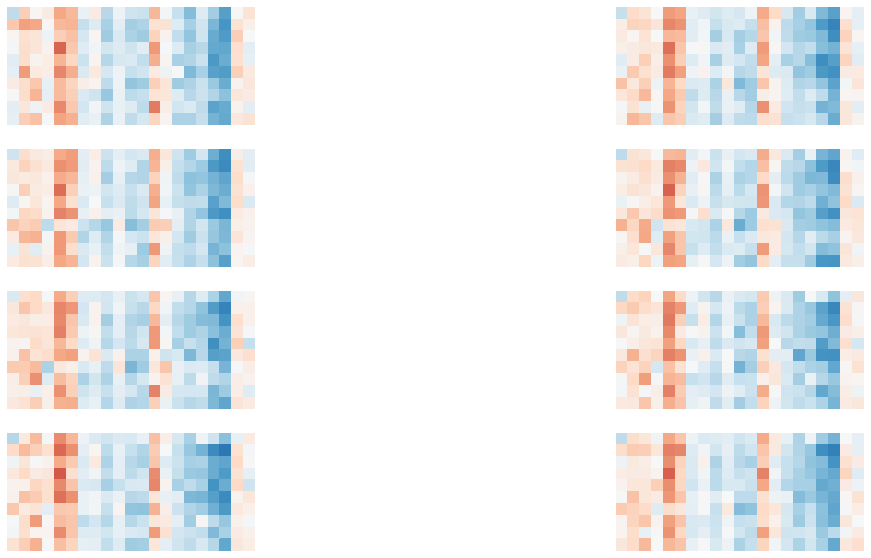

In [19]:
fig, axs = plt.subplots(round(num_matrixConn/2),2,figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(connectome_matrix[0][i], vmin = -1, vmax = 1, cmap = 'RdBu_r',square = True, xticklabels = False,
                yticklabels = False ,cbar = False, ax = ax)

#### Confound regression : aCompCor

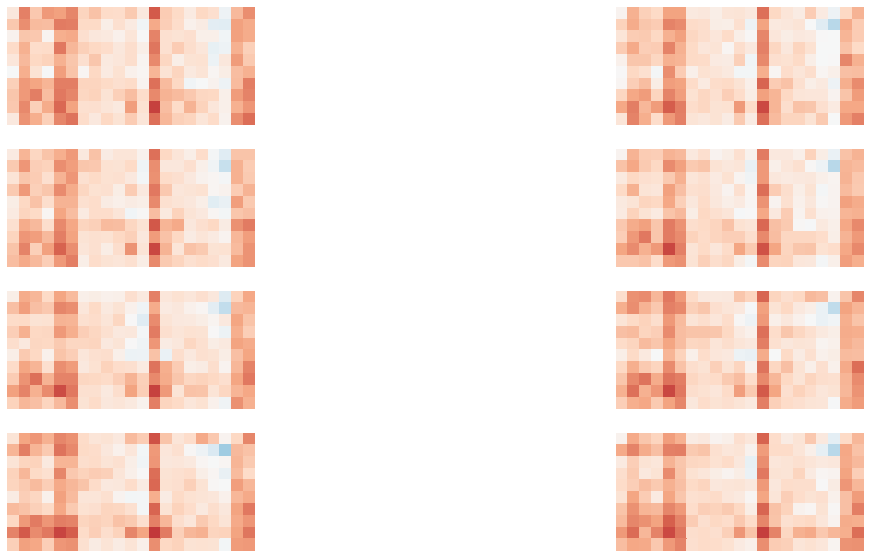

In [20]:
fig, axs = plt.subplots(round(num_matrixConn/2),2,figsize=(20, 10))

for i, ax in enumerate(axs.flatten()):
    sns.heatmap(connectome_matrix[1][i], vmin = -1, vmax = 1, cmap = 'RdBu_r',square = True, xticklabels = False,
                yticklabels = False ,cbar = False, ax = ax)
